# Create your denoise autoencoder using convolutional layers.

## Import necesssary library

In [1]:
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from skimage.util import random_noise

try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

## Define the device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Define the DataLoader for training and validation datasets

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Constants
VAL_SIZE = 0.2
BATCH_SIZE = 64

# Generate indices for train-validation split
train_indices, val_indices, _, _ = train_test_split(
    range(len(mnist_train)),
    mnist_train.targets,
    stratify=mnist_train.targets,
    test_size=VAL_SIZE,
)

# Generate Subset based on indices
train_split = Subset(mnist_train, train_indices)
val_split = Subset(mnist_train, val_indices)

# Create DataLoaders
Tr_dataloader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
Va_dataloader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True)
Ts_dataloader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

## Define the Convolutional Denoise Autoencoder model

In [4]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.to(torch.float32)  # Convert input to float32
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Add noise to the input data

In [5]:
def add_noise(img):
    img_cpu = img.cpu().detach().numpy()  # Move to CPU before converting to NumPy array
    noise = torch.tensor(random_noise(img_cpu, mode='gaussian', seed=None, clip=True), device=device)
    return img + noise

## Define the training function

In [6]:
def train_AE(model, dataloaders, criterion, optimizer, num_epochs=10):
    start = time.time()

    va_loss_history = []
    tr_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val = np.inf

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = dataloaders['train']
            else:
                model.eval()
                dataloader = dataloaders['val']

            running_loss = 0.0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                inputs_noisy = add_noise(inputs)  # Add noise to the input data
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs_noisy)
                    loss = criterion(outputs, inputs)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            if phase == 'val' and epoch_loss < best_val:
                best_val = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

            # Store the loss values correctly
            if phase == 'val':
                va_loss_history.append(epoch_loss)
            if phase == 'train':
                tr_loss_history.append(epoch_loss)  # Append the current loss to the list

        epoch_end = time.time()
        elapsed_epoch = epoch_end - epoch_start
        print("Epoch time taken: {:.0f}m {:.0f}s".format(elapsed_epoch // 60, elapsed_epoch % 60))
        print()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validate Loss: {:.4f}'.format(best_val))
    model.load_state_dict(best_model_wts)
    return model, tr_loss_history, va_loss_history

## Move model to target device (GPU)

In [7]:
model = DenoiseAutoencoder().to(device)

# Print the model architecture using torchsummary
print(model)
summary(model, input_size=(1, 28, 28))  # Assuming MNIST images are 28x28 pixels

DenoiseAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


Layer (type:depth-idx)                   Output Shape              Param #
DenoiseAutoencoder                       [1, 28, 28]               --
├─Sequential: 1-1                        [64, 7, 7]                --
│    └─Conv2d: 2-1                       [32, 28, 28]              320
│    └─ReLU: 2-2                         [32, 28, 28]              --
│    └─MaxPool2d: 2-3                    [32, 14, 14]              --
│    └─Conv2d: 2-4                       [64, 14, 14]              18,496
│    └─ReLU: 2-5                         [64, 14, 14]              --
│    └─MaxPool2d: 2-6                    [64, 7, 7]                --
├─Sequential: 1-2                        [1, 28, 28]               --
│    └─ConvTranspose2d: 2-7              [32, 14, 14]              8,224
│    └─ReLU: 2-8                         [32, 14, 14]              --
│    └─ConvTranspose2d: 2-9              [1, 28, 28]               129
│    └─Sigmoid: 2-10                     [1, 28, 28]               --
Total 

## Define the criterion and optimizer

In [8]:
criterion = nn.MSELoss()
params_to_update = model.parameters()
optimizer = optim.Adam(params_to_update, lr=0.001)

## Train the model

In [9]:
model, tr_loss_history, va_loss_history = train_AE(model, {"train": Tr_dataloader, "val": Va_dataloader}, criterion, optimizer)

Epoch 0/9
----------
train Loss: 0.9034
val Loss: 0.8537
Epoch time taken: 0m 18s

Epoch 1/9
----------
train Loss: 0.8484
val Loss: 0.8396
Epoch time taken: 0m 18s

Epoch 2/9
----------
train Loss: 0.8388
val Loss: 0.8379
Epoch time taken: 0m 19s

Epoch 3/9
----------
train Loss: 0.8377
val Loss: 0.8371
Epoch time taken: 0m 18s

Epoch 4/9
----------
train Loss: 0.8371
val Loss: 0.8366
Epoch time taken: 0m 18s

Epoch 5/9
----------
train Loss: 0.8367
val Loss: 0.8363
Epoch time taken: 0m 18s

Epoch 6/9
----------
train Loss: 0.8364
val Loss: 0.8361
Epoch time taken: 0m 18s

Epoch 7/9
----------
train Loss: 0.8361
val Loss: 0.8359
Epoch time taken: 0m 18s

Epoch 8/9
----------
train Loss: 0.8359
val Loss: 0.8357
Epoch time taken: 0m 17s

Epoch 9/9
----------
train Loss: 0.8358
val Loss: 0.8355
Epoch time taken: 0m 17s

Training complete in 2m 57s
Best Validate Loss: 0.8355


## Move tensors to CPU before plotting

In [10]:
tr_loss_history_cpu = [item.cpu().detach().numpy() if isinstance(item, torch.Tensor) else item for item in tr_loss_history]
va_loss_history_cpu = [item.cpu().detach().numpy() if isinstance(item, torch.Tensor) else item for item in va_loss_history]

## Plot the loss curves

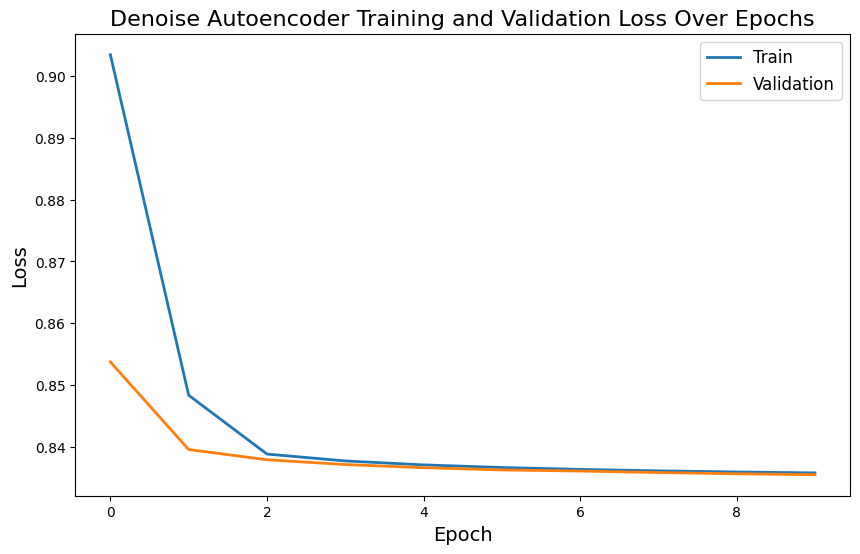

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(tr_loss_history_cpu, label="Train", linewidth=2)
plt.plot(va_loss_history_cpu, label="Validation", linewidth=2)
plt.title('Denoise Autoencoder Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)

## Test the model on the test set (and Plot)

Average Test Loss: 0.8340


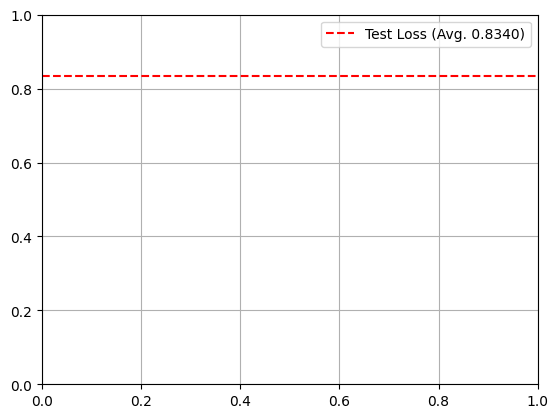

In [12]:
model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in Ts_dataloader:
        inputs = inputs.to(device)
        inputs_noisy = add_noise(inputs)
        outputs = model(inputs_noisy)
        test_loss += criterion(outputs, inputs).item() * inputs.size(0)

average_test_loss = test_loss / len(Ts_dataloader.dataset)
print('Average Test Loss: {:.4f}'.format(average_test_loss))

# Plot the test loss as a horizontal line for comparison
plt.axhline(y=average_test_loss, color='r', linestyle='--', label="Test Loss (Avg. {:.4f})".format(average_test_loss))

# Display the plot
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()